#Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import zipfile
import os
import numpy as np

# Load the dataset

In [5]:
zip_file_path = '/content/online+retail.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_data')  # Extract to a folder called 'extracted_data'

# Check the extracted files
extracted_files = os.listdir('extracted_data')
print(extracted_files)  # This will show the files extracted from the ZIP

['Online Retail.xlsx']


In [6]:
# Load the dataset after extracting it from the ZIP file
file_path = 'extracted_data/Online Retail.xlsx'
df = pd.read_excel(file_path)

# Check the first few rows of the dataset
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


#Data Preprocessing and Analysis

In [7]:
# 1. Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# 2. Remove canceled transactions (negative quantities)
df = df[df['Quantity'] > 0]

# 3. Create a 'TotalPrice' column for each transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 4. Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 5. Create customer-level features (Recency, Frequency, Monetary - RFM)
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary Value
}).reset_index()

# Rename the columns for clarity
customer_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

#Creating Target Variable

In [8]:
# Create the target variable: 1 if customer made a purchase in the last X days, else 0
# For example, if Recency <= 30 days, the customer made a purchase recently
customer_df['target'] = np.where(customer_df['Recency'] <= 30, 1, 0)


#EDA

Basic Data Overview:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ---

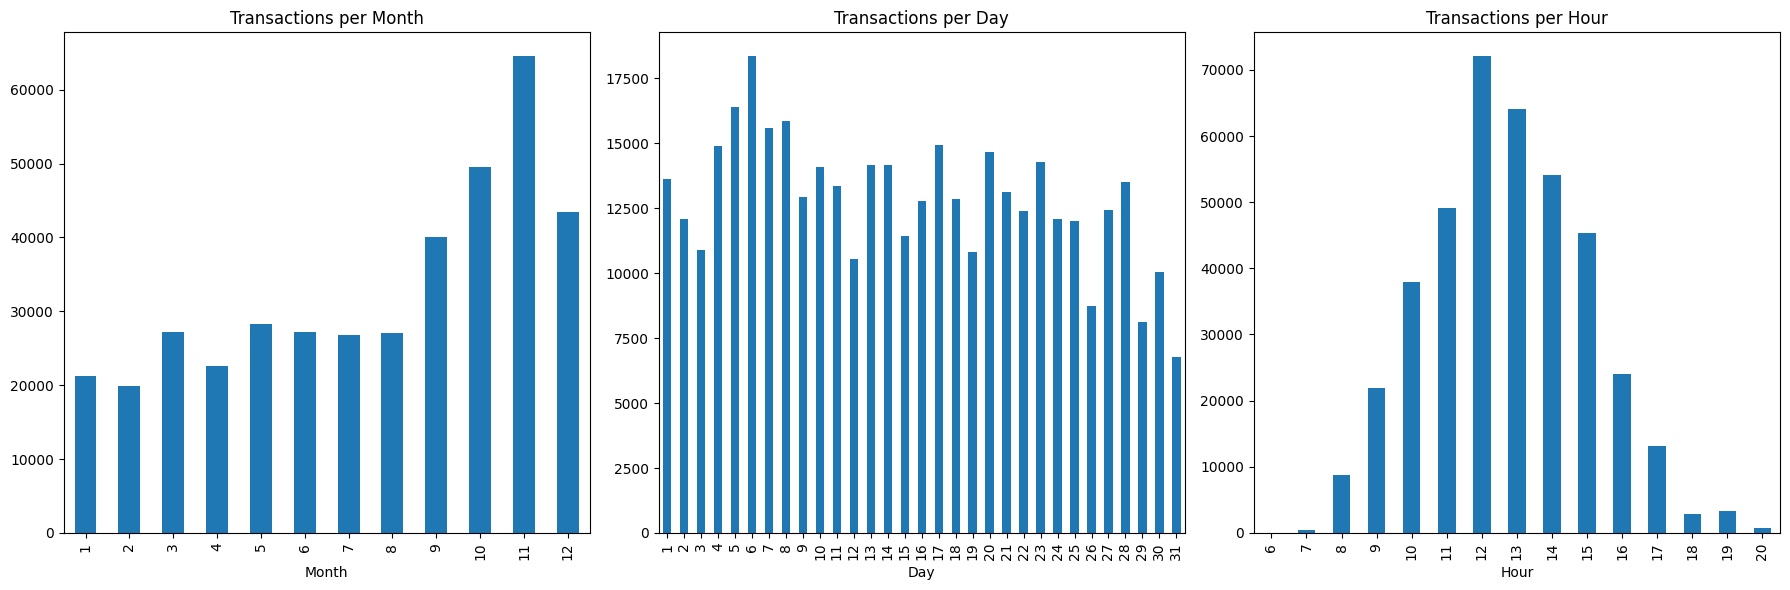

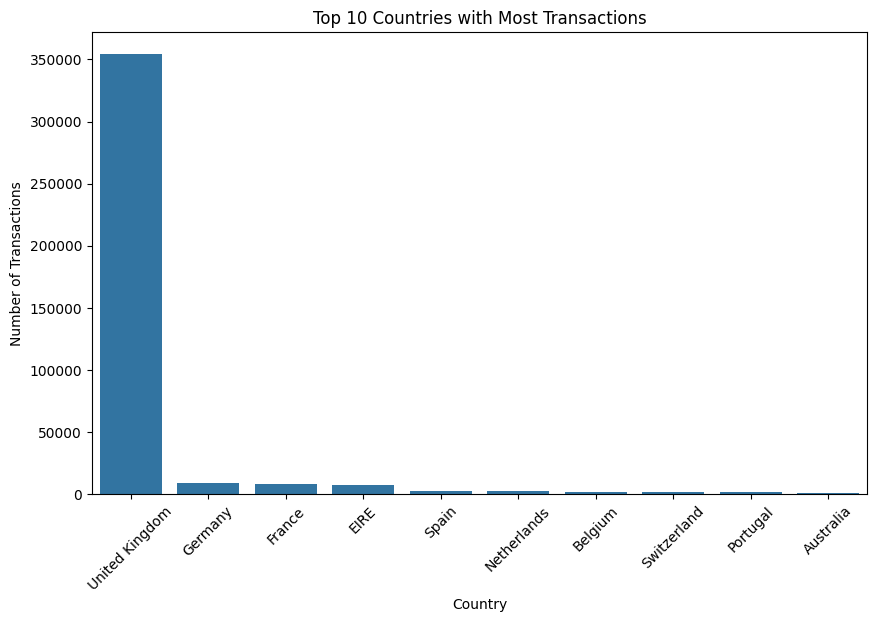

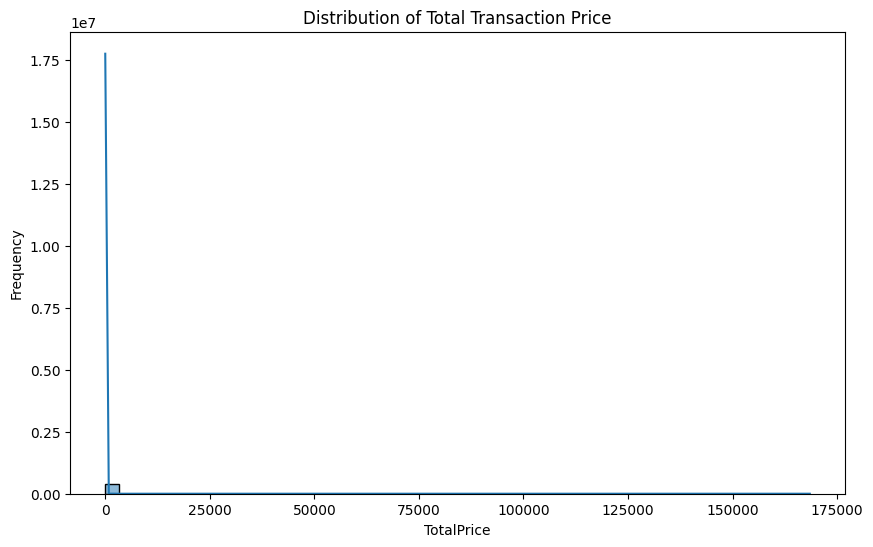

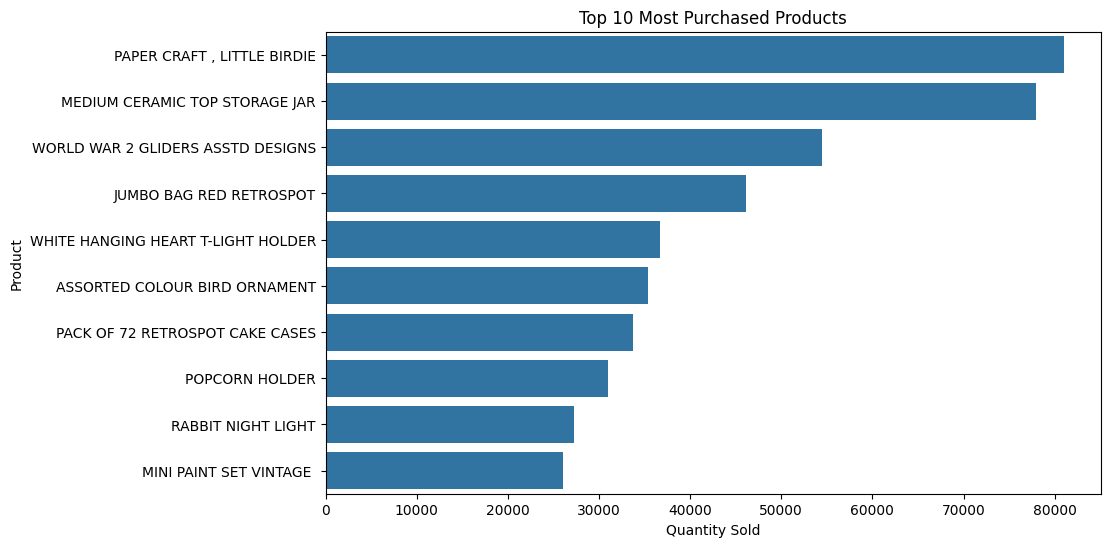

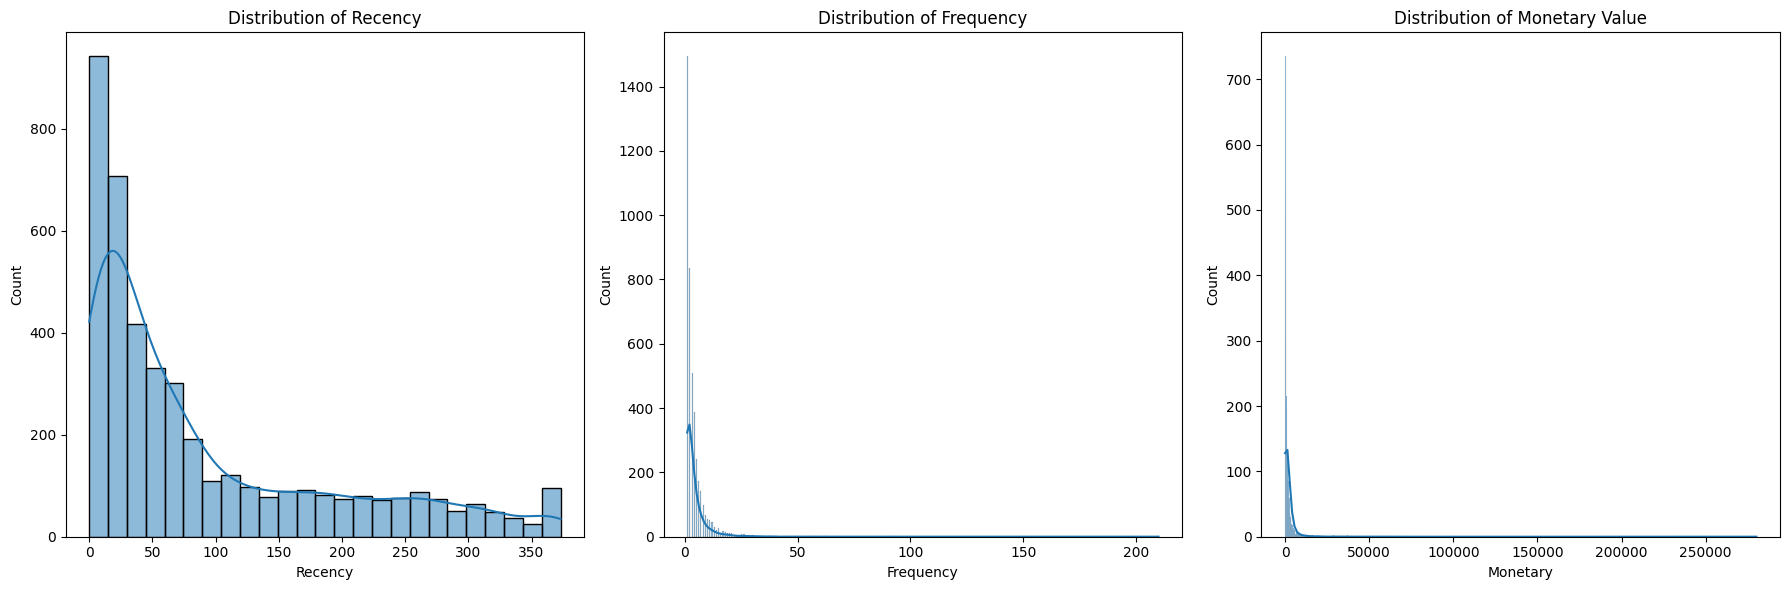

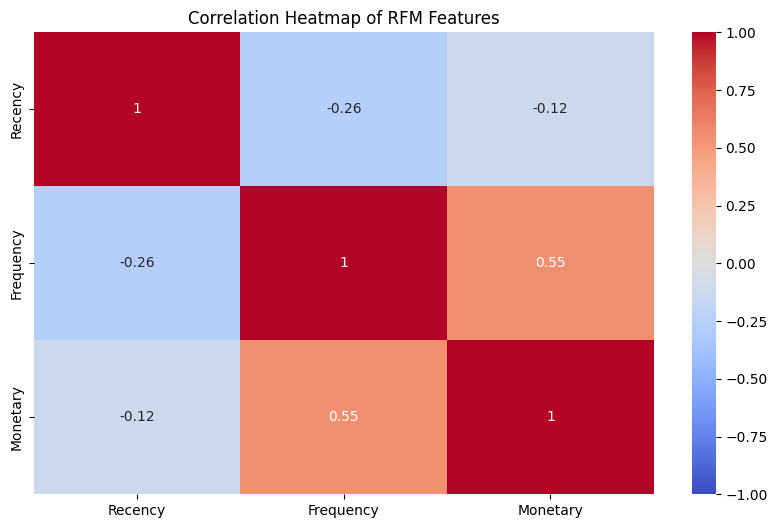

In [16]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_excel('/content/extracted_data/Online Retail.xlsx')

# 1. Basic Data Overview
print("Basic Data Overview:")
print(df.head())  # Display first few rows
print(df.info())  # Overview of data types and non-null counts
print(df.isnull().sum())  # Check for missing values
print(df.describe())  # Basic statistics of numerical columns

# 2. Handling Missing Values
df_clean = df.dropna(subset=['CustomerID', 'Description'])  # Drop rows with missing CustomerID and Description

# 3. Handling Canceled Orders (remove rows with negative quantities)
df_clean = df_clean[df_clean['Quantity'] > 0]

# 4. Extracting Date and Time Features
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

# Plot distribution of transactions over time (Month, Day, Hour)
plt.figure(figsize=(18,6))

plt.subplot(1, 3, 1)
df_clean.groupby('Month').size().plot(kind='bar', title='Transactions per Month')

plt.subplot(1, 3, 2)
df_clean.groupby('Day').size().plot(kind='bar', title='Transactions per Day')

plt.subplot(1, 3, 3)
df_clean.groupby('Hour').size().plot(kind='bar', title='Transactions per Hour')

plt.tight_layout()
plt.show()

# 5. Exploratory Data Visualization
# A. Distribution of Purchases by Country
top_countries = df_clean['Country'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 Countries with Most Transactions")
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

# B. Distribution of Total Sales (Monetary)
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']  # Create TotalPrice column

# Plot distribution of TotalPrice
plt.figure(figsize=(10,6))
sns.histplot(df_clean['TotalPrice'], bins=50, kde=True)
plt.title('Distribution of Total Transaction Price')
plt.xlabel('TotalPrice')
plt.ylabel('Frequency')
plt.show()

# 6. Top Products Purchased
top_products = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Most Purchased Products")
plt.xlabel('Quantity Sold')
plt.ylabel('Product')
plt.show()

# 7. RFM (Recency, Frequency, Monetary) Analysis
latest_date = df_clean['InvoiceDate'].max()

rfm_df = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']  # Rename columns

# Plot distributions of RFM features
plt.figure(figsize=(18,6))

plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], kde=True)
plt.title('Distribution of Recency')

plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], kde=True)
plt.title('Distribution of Frequency')

plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], kde=True)
plt.title('Distribution of Monetary Value')

plt.tight_layout()
plt.show()

# 8. Correlation Analysis
plt.figure(figsize=(10,6))
sns.heatmap(rfm_df[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of RFM Features")
plt.show()


#Splitting Data for Training and Testing

In [9]:
X = customer_df.drop(columns=['CustomerID', 'target'])
y = customer_df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Model Building and Training Block

Logistic Regression

In [10]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Predict using Logistic Regression
y_pred_logreg = logreg.predict(X_test_scaled)

 XGBoost Regression (Classifier in our case)

In [11]:
# Train XGBoost Classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

#Model Evaluation

In [12]:
# Logistic Regression Evaluation
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Precision:", precision_score(y_test, y_pred_logreg))
print("Recall:", recall_score(y_test, y_pred_logreg))
print("F1 Score:", f1_score(y_test, y_pred_logreg))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_logreg))

# XGBoost Evaluation
print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_xgb))


Logistic Regression:
Accuracy: 0.9861751152073732
Precision: 0.9661016949152542
Recall: 1.0
F1 Score: 0.9827586206896551
AUC-ROC: 0.9885931558935361

XGBoost:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC-ROC: 1.0


#Output

In [13]:
def interactive_input_and_prediction():
    print("Please enter the following customer data for prediction:")

    # Taking inputs for Recency, Frequency, and Monetary value
    recency = int(input("Recency (days since last purchase): "))
    frequency = int(input("Frequency (number of purchases): "))
    monetary = float(input("Monetary (total spend): "))

    # Create a dataframe for the input customer data
    customer_input = pd.DataFrame([[recency, frequency, monetary]],
                                  columns=['Recency', 'Frequency', 'Monetary'])

    # Scale the input for Logistic Regression
    customer_input_scaled = scaler.transform(customer_input)

    # Logistic Regression Prediction
    logreg_pred = logreg.predict(customer_input_scaled)
    logreg_prob = logreg.predict_proba(customer_input_scaled)[:, 1]

    # XGBoost Prediction
    xgb_pred = xgb_model.predict(customer_input)
    xgb_prob = xgb_model.predict_proba(customer_input)[:, 1]

    # Display results
    print("\n===== Prediction Results =====")
    print(f"Customer Input: Recency = {recency}, Frequency = {frequency}, Monetary = {monetary}")
    print("\nLogistic Regression Prediction:")
    print("Prediction:", "Purchase" if logreg_pred[0] == 1 else "No Purchase")
    print(f"Probability of Purchase: {logreg_prob[0]:.2f}")

    print("\nXGBoost Prediction:")
    print("Prediction:", "Purchase" if xgb_pred[0] == 1 else "No Purchase")
    print(f"Probability of Purchase: {xgb_prob[0]:.2f}")

# Call the interactive function
interactive_input_and_prediction()


Please enter the following customer data for prediction:
Recency (days since last purchase): 23
Frequency (number of purchases): 4
Monetary (total spend): 5

===== Prediction Results =====
Customer Input: Recency = 23, Frequency = 4, Monetary = 5.0

Logistic Regression Prediction:
Prediction: Purchase
Probability of Purchase: 0.83

XGBoost Prediction:
Prediction: Purchase
Probability of Purchase: 1.00
